LDA:

1. Calculate the assumed common covariance matrix
2. Calculate the means for each of the two classes
3. Plug into the formula $f_{kl}(x)=wx+b$, when $f(x) < 0$, predicted class: $l$, else predicted class: $k$
   1. $w=(\mu_k-\mu_l)^T\Sigma^{-1}$
   2. $b=-\frac{1}{2}(\mu_k\mu_l)^T\Sigma^{-1}(\mu_k+\mu_l)+log\frac{N_k}{N_l}$

QDA:

1. Calculate the covariance matrix for each of the two classes
2. Calculate the means for each of the two classes
3. Plug into the formula $f_{21}(x)=\frac{1}{2}\log\frac{|\Sigma_1|}{|\Sigma_2|}+x^T(\Sigma_2^{-1}\mu_2-\Sigma_1^{-1}\mu_1)-\frac{1}{2}x^T(\Sigma_2^{-1}-\Sigma_1^{-1})x-\frac{1}{2}\mu_2^T\Sigma_2^{-1}\mu_2+\frac{1}{2}\mu_1^T\Sigma_1^{-1}\mu_1+\log\frac{N_2}{N_1}$ when the f(x) > 0 assign class 2, else assign class 1

NB:

1. Calculate mean, variance and priors for the two classes for each feature
2. Given an observation, sum up the log of probabilities of the observation's features assuming normal distribution plus the prior
3. Choose the class with a higher posterior probability as the predicted class


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
from scipy.io.arff import loadarff
import pandas as pd

C:\Users\prusak.patryk\AppData\Local\Temp\ipykernel_35344\2230573426.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [54]:
class LDA:
    def __init__(self):
        self.w=0
        self.b=0
        self.mean_0=0
        self.mean_1=0
        self.covariance_matrix=0

    def fit(self,X,y):
        classes= np.unique(y)
        self.covariance_matrix = np.cov(X[y==classes[0]].T)
        self.mean_0=np.mean(X[y==classes[0]], axis=0)
        self.mean_1=np.mean(X[y==classes[1]], axis=0)

        covariance_matrix_inverse = np.linalg.inv(self.covariance_matrix)
        no_0 = (y==classes[0]).sum()
        no_1=(y==classes[1]).sum()
        # class 0 being class k, and class 1 being class l
        self.w=(self.mean_0-self.mean_1).T.dot(covariance_matrix_inverse)
        self.b=-(1/2)*(self.mean_0-self.mean_1).T.dot(covariance_matrix_inverse).dot((self.mean_0+self.mean_1))+np.log(no_0/no_1)

        
    def predict_proba(self, Xtest):
        if Xtest.ndim>=2:
            f= []
            for x in Xtest:
                f.append(self.w.dot(x)+self.b)
        else:
            f=self.w.dot(Xtest)+self.b
        # print("Predicted: ",f)
        return -f
    def predict(self, Xtest):
        
        if Xtest.ndim>=2:
            f= []
            for x in Xtest:
                if np.sign(self.w.dot(x)+self.b) == -1:
                    f.append(1)
                else:
                    f.append(0)
        else:
            if np.sign(self.w.dot(Xtest)+self.b) == -1:
                f=1
            else:
                f=0
        # print("Predicted class: ",1 if f==-1 else 0)
        return f
    def get_params(self):
        print("w: ",self.w ,"\nb: ",self.b, "\nm_0: ",self.mean_0, "\nm_1: ",self.mean_1,"\ncovariance matrix: ",self.covariance_matrix)
        return (self.w, self.b,self.mean_0,self.mean_1,self.covariance_matrix)
    
class QDA:
    def __init__(self):
        self.mean_0=0
        self.mean_1=0
        self.covariance_matrix_0=0
        self.covariance_matrix_1=0
        self.covariance_matrix_inverse_0 = 0
        self.covariance_matrix_inverse_1 = 0
        self.no_0 = 0
        self.no_1 = 0

    def fit(self,X,y):
        classes= np.unique(y)
        self.covariance_matrix_0 = np.cov(X[y==classes[0]].T)
   
        self.covariance_matrix_1 = np.cov(X[y==classes[1]].T)
        self.mean_0=np.mean(X[y==classes[0]], axis=0)
        self.mean_1=np.mean(X[y==classes[1]], axis=0)
        self.covariance_matrix_inverse_0 = np.linalg.inv(self.covariance_matrix_0)
        self.covariance_matrix_inverse_1 = np.linalg.inv(self.covariance_matrix_1)

        self.no_0 = (y==classes[0]).sum()
        self.no_1=(y==classes[1]).sum()

    def compute(self,Xtest):
        return 1/2*(np.log(np.linalg.det(self.covariance_matrix_0)/np.linalg.det(self.covariance_matrix_1)))+Xtest.T.dot(self.covariance_matrix_inverse_1.dot(self.mean_1)-self.covariance_matrix_inverse_0.dot(self.mean_0))-1/2*Xtest.T.dot(self.covariance_matrix_inverse_1-self.covariance_matrix_inverse_0).dot(Xtest)-1/2*(self.mean_1.T.dot(self.covariance_matrix_inverse_1).dot(self.mean_1))+1/2*self.mean_0.T.dot(self.covariance_matrix_inverse_0).dot(self.mean_0)+np.log(self.no_1/self.no_0)
    def predict_proba(self,Xtest):
        if Xtest.ndim>=2:
            f= []
            for x in Xtest:
                f.append(self.compute(x))
        else:
            f = self.compute(Xtest)

        return f
    def predict(self,Xtest):
        if Xtest.ndim>=2:
            f= []
            for x in Xtest:
                if self.compute(x) > 0:
                    f.append(1)
                else:
                    f.append(0)
        else:
            if self.compute(Xtest) > 0:
                f = 1
            else:
                f = 0
        return f

    def get_params(self):
        print("\nm_0: ",self.mean_0, "\nm_1: ",self.mean_1,"\ncov_0: ",self.covariance_matrix_0,"\ncov_1: ",self.covariance_matrix_1,"\ncov_0 inverse: ",self.covariance_matrix_inverse_0,"\ncov_1 inverse: ",self.covariance_matrix_inverse_1)
        return (self.mean_0, self.mean_1,self.covariance_matrix_0,self.covariance_matrix_1,self.covariance_matrix_inverse_0,self.covariance_matrix_inverse_1)
    

class NB:
    def __init__(self):
        self.mean_0=0
        self.variance_0=0
        self.prior_0=0
        self.mean_1=0
        self.variance_1=0
        self.prior_1=0
    def fit(self,X,y):
        classes=np.unique(y)
        self.mean_0=np.mean(X[y==classes[0]], axis=0)
        self.mean_1=np.mean(X[y==classes[1]], axis=0)
        self.variance_0=np.var(X[y==classes[0]], axis=0)
        self.variance_1=np.var(X[y==classes[1]], axis=0)
        self.prior_0=len(X[y==classes[0]])/len(y)
        self.prior_1=len(X[y==classes[1]])/len(y)




    def predict_proba_single(self,Xtest):
        prob_1=np.log(self.prior_1)
        idx=0
        for x in Xtest:
            prob_1=prob_1+np.log(self.normal(mean=self.mean_1[idx], variance=self.variance_1[idx],x=x))
            idx=idx+1
        return prob_1
    def normal(self,x, mean, variance):
        return math.exp(-1/2*math.pow((x-mean)/variance,2))/variance*math.sqrt(2*math.pi)

    def predict_single(self,Xtest):

        prob_0=np.log(self.prior_0)
        idx=0
        for x in Xtest:
            prob_0=prob_0+np.log(self.normal(mean=self.mean_0[idx], variance=self.variance_0[idx],x=x))
            idx=idx+1

        prob_1=np.log(self.prior_1)
        idx=0
        for x in Xtest:
            prob_1=prob_1+np.log(self.normal(mean=self.mean_1[idx], variance=self.variance_1[idx],x=x))
            idx=idx+1

        if prob_1>prob_0:
            return 1
        else:
            return 0
    def predict_proba(self,Xtest):
        if Xtest.ndim>=2:
            f = []
            for x in Xtest:
                f.append(self.predict_proba_single(x))
        else:
            f=self.predict_proba_single(Xtest)
        return f
    def predict(self,Xtest):
        if Xtest.ndim>=2:
            f = []
            for x in Xtest:
                f.append(self.predict_single(x))
        else:
            f=self.predict_single(Xtest)
        return f


    def get_params(self):
        print("\nm_0: ",self.mean_0, "\nm_1: ",self.mean_1,"\nvar_0: ",self.variance_0,"\nvar_1: ",self.variance_1,"\nprior_0: ",self.prior_0,"\nprior_1: ",self.prior_1)
        return (self.mean_0, self.mean_1,self.variance_0,self.variance_1,self.prior_0,self.prior_1)
    
    



#### Data generation


In [55]:
def scheme_1_data_generator(a):
    n=1000
    bern_prob=0.5
    y=np.random.binomial(size=n, n=1, p= bern_prob)
    feature_0_0 = np.random.normal(0, 1, size=(1, n)).T
    feature_0_1 = np.random.normal(0, 1, size=(1, n)).T
    feature_0=np.hstack([feature_0_0,feature_0_1])

    feature_1_0 = np.random.normal(a, 1, size=(1, n)).T
    feature_1_1 = np.random.normal(a, 1, size=(1, n)).T
    feature_1=np.hstack([feature_1_0,feature_1_1])
    
    X = np.concatenate((feature_0[y==0],feature_1[y==1]))
    return (X,y)
def scheme_2_data_generator(mean,rho):
    n=1000
    bern_prob=0.5
    y=np.random.binomial(size=n, n=1, p= bern_prob)
    # cov(X,Y) = corr(X,Y)*std(X)*std(Y)
    features_0 = np.random.multivariate_normal([0,0], [[1,rho],[rho,1]], n)
    features_1 = np.random.multivariate_normal([mean,mean], [[1,-rho],[-rho,1]], n)
    X = np.concatenate((features_0[y==0],features_1[y==1]))
    return (X,y)


#### Accuracy


In [56]:
def get_accuracy(model:LDA|QDA|NB,X_test,y_test):
    correct=0
    index =0
    for x in X_test:
        result=model.predict(x)
        if result==y_test[index]:
            correct=correct + 1
        index = index + 1
    return correct/len(y_test)

### Comparison #1


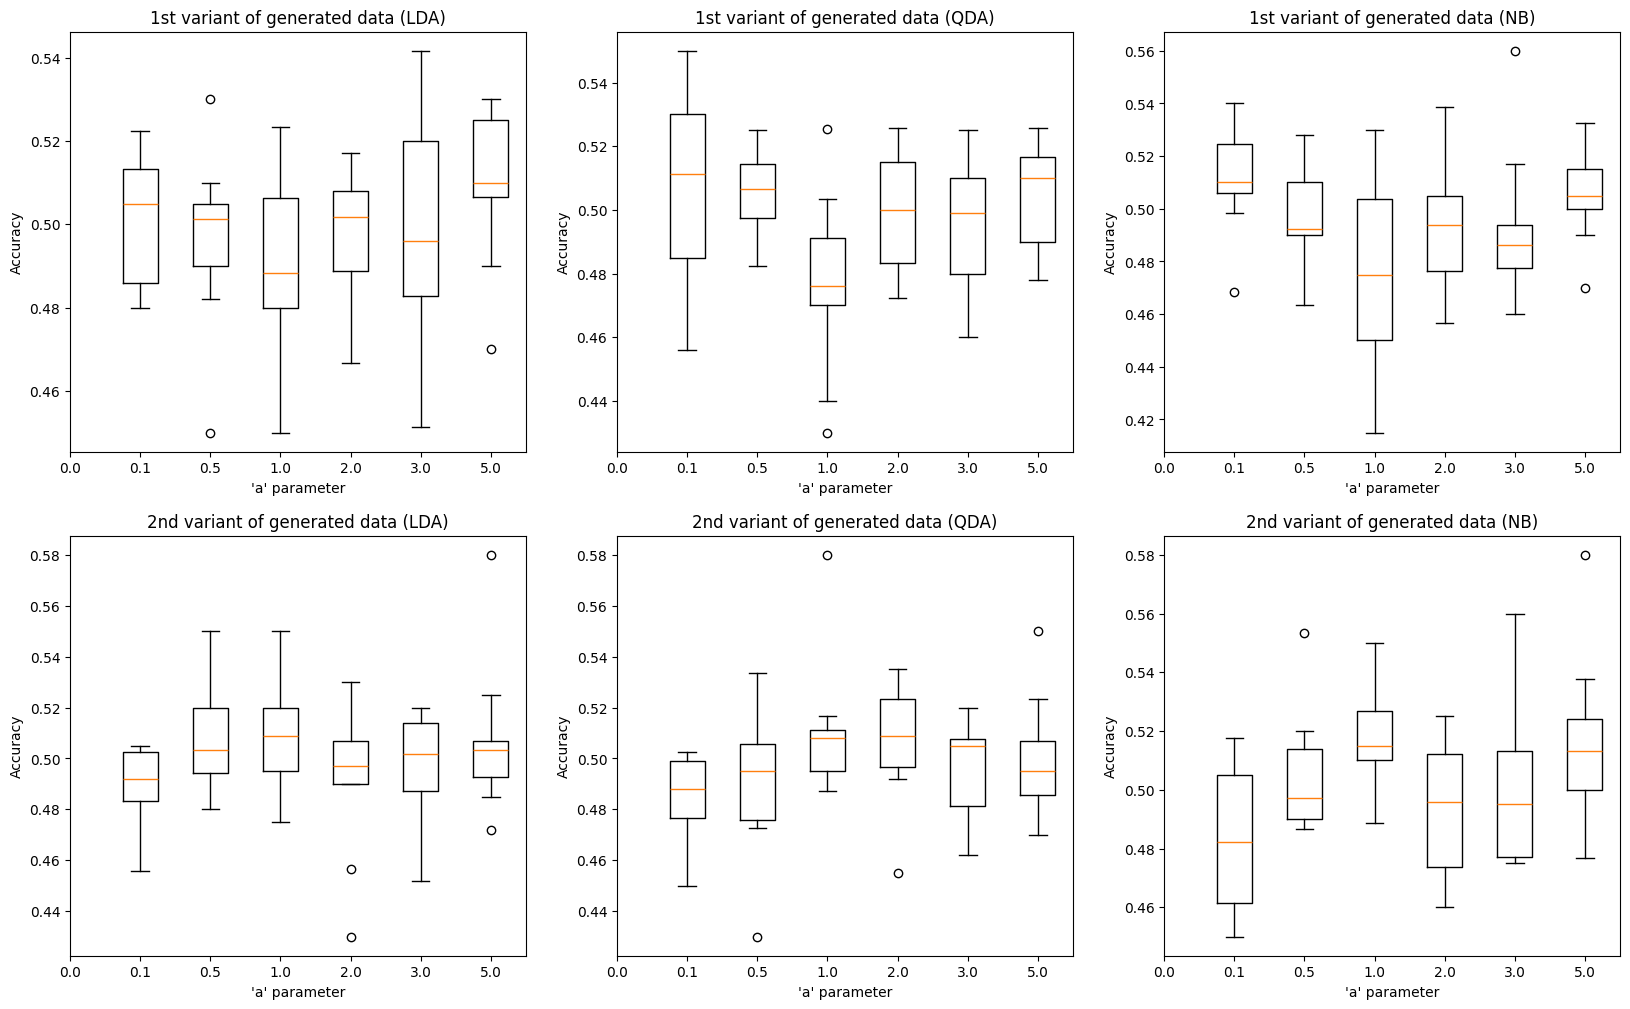

In [57]:

lda=LDA()
qda=QDA()
nb=NB()
# scheme_2_data_generator(1,0.5)
splits = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
a_params = [0.1,0.5,1,2,3,5]
accuracies_scheme_1={'lda':[],'qda':[],'nb':[]}
accuracies_scheme_2={'lda':[],'qda':[],'nb':[]}


for a in a_params:
    accuracy_scheme_1={'lda':[],'qda':[],'nb':[]}
    accuracy_scheme_2={'lda':[],'qda':[],'nb':[]}

    for x in splits:

        (X,y)=scheme_1_data_generator(a)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=x, random_state=42)
        lda.fit(X_train,y_train)      
        accuracy_scheme_1['lda'].append(get_accuracy(lda,X_test,y_test))

        qda.fit(X_train,y_train)
        accuracy_scheme_1['qda'].append(get_accuracy(qda,X_test,y_test))

        nb.fit(X_train,y_train)
        accuracy_scheme_1['nb'].append(get_accuracy(nb,X_test,y_test))


        (X,y)=scheme_2_data_generator(a,0.5)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=x, random_state=42)
        lda.fit(X_train,y_train)
        accuracy_scheme_2['lda'].append(get_accuracy(lda,X_test,y_test))

        qda.fit(X_train,y_train)
        accuracy_scheme_2['qda'].append(get_accuracy(qda,X_test,y_test))

        nb.fit(X_train,y_train)
        accuracy_scheme_2['nb'].append(get_accuracy(nb,X_test,y_test))

    accuracies_scheme_1['lda'].append(accuracy_scheme_1['lda'])
    accuracies_scheme_2['lda'].append(accuracy_scheme_2['lda'])

    accuracies_scheme_1['qda'].append(accuracy_scheme_1['qda'])
    accuracies_scheme_2['qda'].append(accuracy_scheme_2['qda'])

    accuracies_scheme_1['nb'].append(accuracy_scheme_1['nb'])
    accuracies_scheme_2['nb'].append(accuracy_scheme_2['nb'])

fig, axs = plt.subplots(2,3, figsize=(20,12))
axs[0,0].boxplot(accuracies_scheme_1['lda'])
axs[0,0].set_xticks(list(range(len(a_params)+1)),np.concatenate(([0],a_params)))
axs[0,0].set_title("1st variant of generated data (LDA)")
axs[0,0].set_ylabel("Accuracy")
axs[0,0].set_xlabel("'a' parameter")

      
axs[0,1].boxplot(accuracies_scheme_1['qda'])
axs[0,1].set_xticks(list(range(len(a_params)+1)),np.concatenate(([0],a_params)))
axs[0,1].set_title("1st variant of generated data (QDA)")
axs[0,1].set_ylabel("Accuracy")
axs[0,1].set_xlabel("'a' parameter")

axs[0,2].boxplot(accuracies_scheme_1['nb'])
axs[0,2].set_xticks(list(range(len(a_params)+1)),np.concatenate(([0],a_params)))
axs[0,2].set_title("1st variant of generated data (NB)")
axs[0,2].set_ylabel("Accuracy")
axs[0,2].set_xlabel("'a' parameter")

axs[1,0].boxplot(accuracies_scheme_2['lda'])
axs[1,0].set_xticks(list(range(len(a_params)+1)),np.concatenate(([0],a_params)))
axs[1,0].set_title("2nd variant of generated data (LDA)")
axs[1,0].set_ylabel("Accuracy")
axs[1,0].set_xlabel("'a' parameter")

      
axs[1,1].boxplot(accuracies_scheme_2['qda'])
axs[1,1].set_xticks(list(range(len(a_params)+1)),np.concatenate(([0],a_params)))
axs[1,1].set_title("2nd variant of generated data (QDA)")
axs[1,1].set_ylabel("Accuracy")
axs[1,1].set_xlabel("'a' parameter")

axs[1,2].boxplot(accuracies_scheme_2['nb'])
axs[1,2].set_xticks(list(range(len(a_params)+1)),np.concatenate(([0],a_params)))
axs[1,2].set_title("2nd variant of generated data (NB)")
axs[1,2].set_ylabel("Accuracy")
axs[1,2].set_xlabel("'a' parameter")
plt.savefig('BayesianSimulatedData1.pdf')
plt.show()  



#### Comparison #2


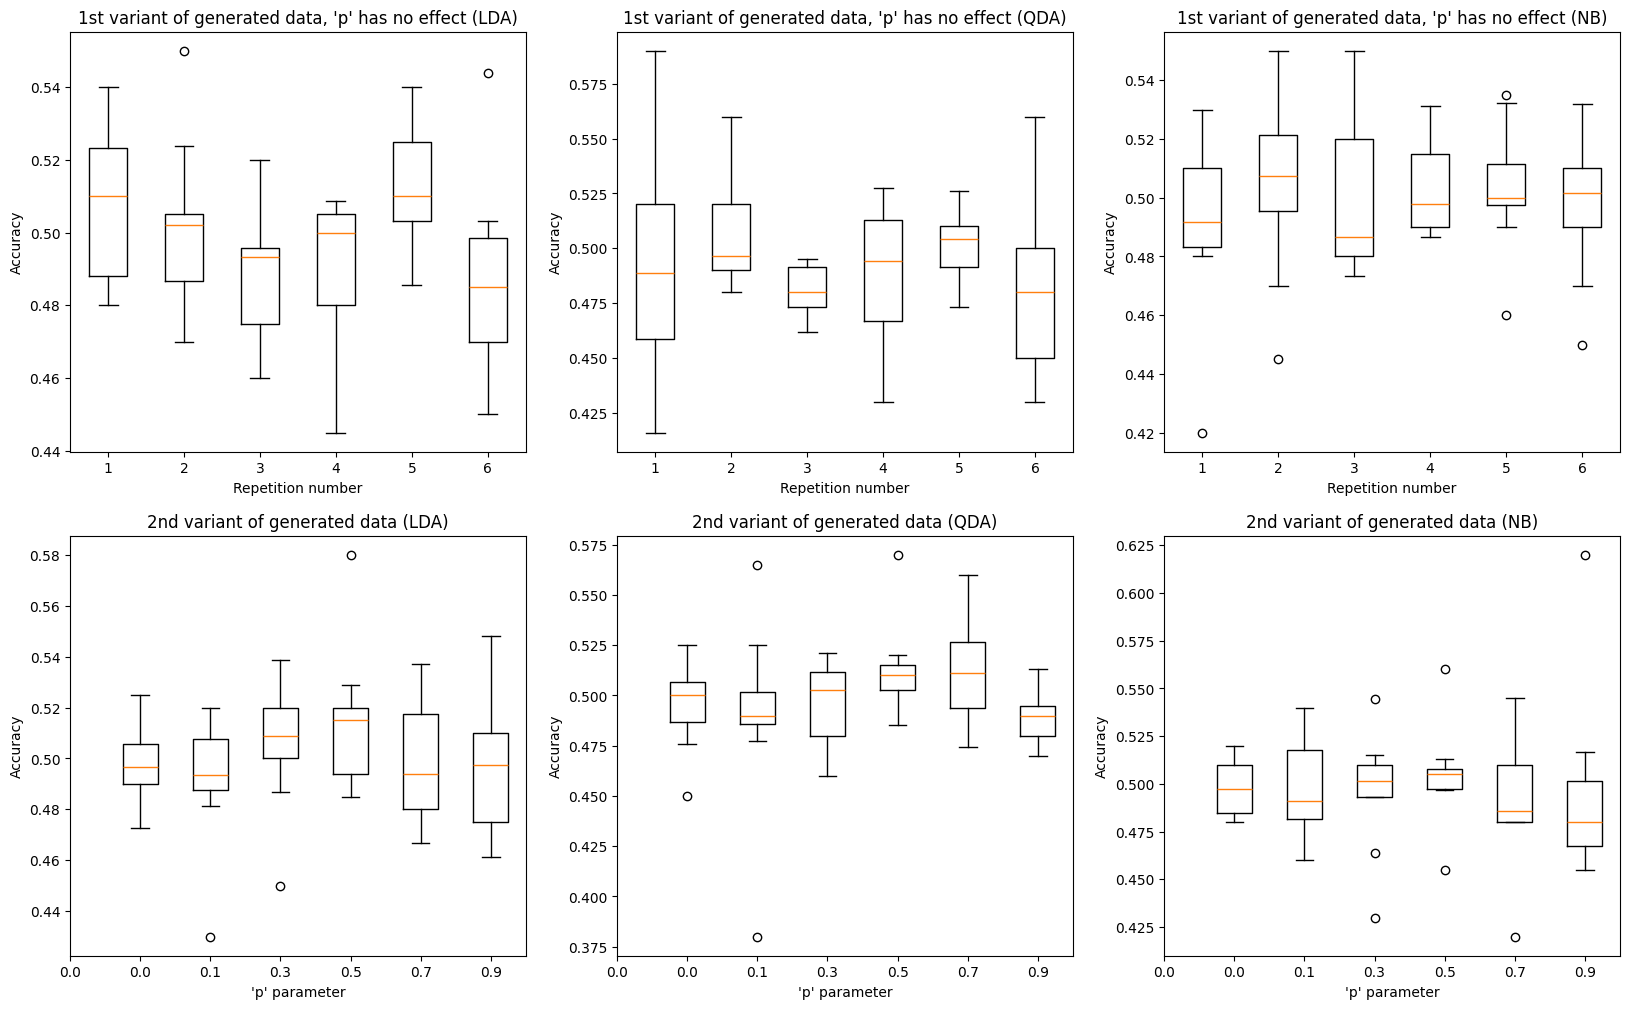

In [58]:
lda=LDA()
qda = QDA()
nb=NB()
splits = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
p_params = [0,0.1,0.3,0.5,0.7,0.9]
accuracies_scheme_1={'lda':[],'qda':[],'nb':[]}
accuracies_scheme_2={'lda':[],'qda':[],'nb':[]}
for p in p_params:
    accuracy_scheme_1={'lda':[],'qda':[],'nb':[]}
    accuracy_scheme_2={'lda':[],'qda':[],'nb':[]}
    for x in splits:
        (X,y)=scheme_1_data_generator(2)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=x, random_state=42)
        lda.fit(X_train,y_train)
        accuracy_scheme_1['lda'].append(get_accuracy(lda,X_test,y_test))

        qda.fit(X_train,y_train)
        accuracy_scheme_1['qda'].append(get_accuracy(qda,X_test,y_test))

        nb.fit(X_train,y_train)
        accuracy_scheme_1['nb'].append(get_accuracy(nb,X_test,y_test))


        (X,y)=scheme_2_data_generator(2,p)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=x, random_state=42)
        lda.fit(X_train,y_train)
        accuracy_scheme_2['lda'].append(get_accuracy(lda,X_test,y_test))

        qda.fit(X_train,y_train)
        accuracy_scheme_2['qda'].append(get_accuracy(qda,X_test,y_test))

        nb.fit(X_train,y_train)
        accuracy_scheme_2['nb'].append(get_accuracy(nb,X_test,y_test))

    accuracies_scheme_1['lda'].append(accuracy_scheme_1['lda'])
    accuracies_scheme_2['lda'].append(accuracy_scheme_2['lda'])

    accuracies_scheme_1['qda'].append(accuracy_scheme_1['qda'])
    accuracies_scheme_2['qda'].append(accuracy_scheme_2['qda'])

    accuracies_scheme_1['nb'].append(accuracy_scheme_1['nb'])
    accuracies_scheme_2['nb'].append(accuracy_scheme_2['nb'])

fig, axs = plt.subplots(2,3, figsize=(20,12))
axs[0,0].boxplot(accuracies_scheme_1['lda'])
axs[0,0].set_title("1st variant of generated data, 'p' has no effect (LDA)")
axs[0,0].set_ylabel("Accuracy")
axs[0,0].set_xlabel("Repetition number")

      
axs[0,1].boxplot(accuracies_scheme_1['qda'])
axs[0,1].set_title("1st variant of generated data, 'p' has no effect (QDA)")
axs[0,1].set_ylabel("Accuracy")
axs[0,1].set_xlabel("Repetition number")

axs[0,2].boxplot(accuracies_scheme_1['nb'])
axs[0,2].set_title("1st variant of generated data, 'p' has no effect (NB)")
axs[0,2].set_ylabel("Accuracy")
axs[0,2].set_xlabel("Repetition number")


axs[1,0].boxplot(accuracies_scheme_2['lda'])
axs[1,0].set_xticks(list(range(len(p_params)+1)),np.concatenate(([0],p_params)))
axs[1,0].set_title("2nd variant of generated data (LDA)")
axs[1,0].set_ylabel("Accuracy")
axs[1,0].set_xlabel("'p' parameter")

      
axs[1,1].boxplot(accuracies_scheme_2['qda'])
axs[1,1].set_xticks(list(range(len(p_params)+1)),np.concatenate(([0],p_params)))
axs[1,1].set_title("2nd variant of generated data (QDA)")
axs[1,1].set_ylabel("Accuracy")
axs[1,1].set_xlabel("'p' parameter")

axs[1,2].boxplot(accuracies_scheme_2['nb'])
axs[1,2].set_xticks(list(range(len(p_params)+1)),np.concatenate(([0],p_params)))
axs[1,2].set_title("2nd variant of generated data (NB)")
axs[1,2].set_ylabel("Accuracy")
axs[1,2].set_xlabel("'p' parameter")
plt.savefig('BayesianSimulatedData2.pdf')
plt.show()    


#### Comparison #3


w:  [-0.01148554 -0.03877956] 
b:  0.2163236882848954 
m_0:  [0.88979764 0.81772563] 
m_1:  [0.94780929 0.90198457] 
covariance matrix:  [[1.98633501 0.90763067]
 [0.90763067 1.90394917]]
w:  [ 0.03404311 -0.03643938] 
b:  -0.03313511227562392 
m_0:  [1.02160598 0.99715301] 
m_1:  [0.98938127 1.03904538] 
covariance matrix:  [[1.95975244 0.94654051]
 [0.94654051 2.03394096]]


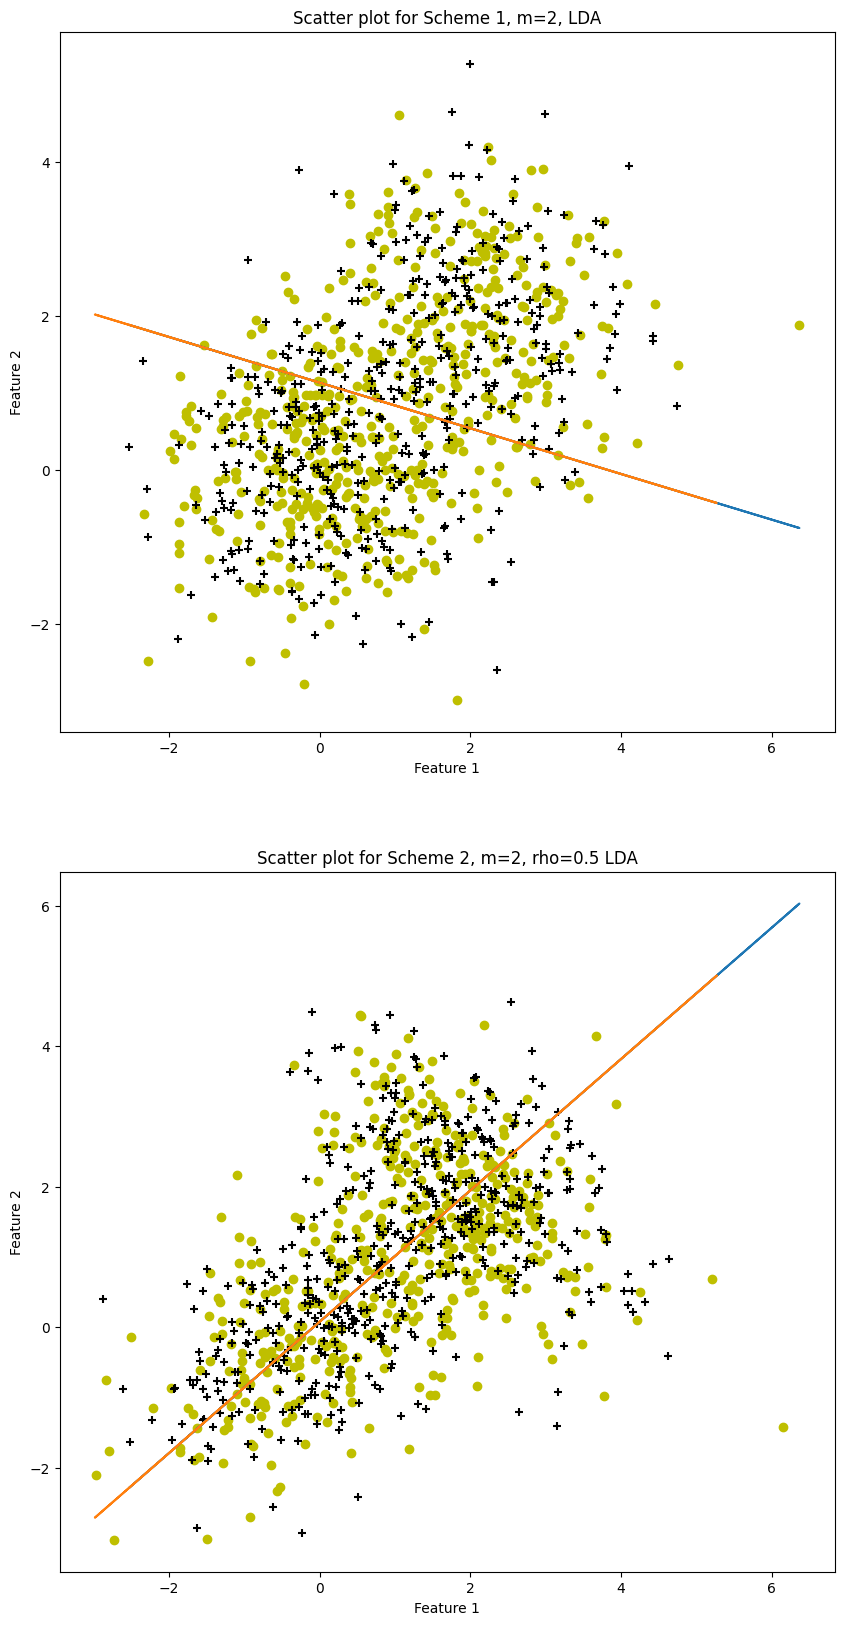

In [59]:
(X_1,y_1)=scheme_1_data_generator(2)
(X_2,y_2)=scheme_2_data_generator(2,0.5)
lda=LDA()

x_class_0 = np.where(y_1==0)
x_class_1 = np.where(y_1==1)
fig, axs = plt.subplots(2,1, figsize=(10,20))
axs[0].scatter([row[0] for row in X_1[x_class_0]],[row[1] for row in X_1[x_class_0]], marker='o',c='y')
axs[0].scatter([row[0] for row in X_1[x_class_1]],[row[1] for row in X_1[x_class_1]], marker='+',c='k')
lda.fit(X_1,y_1)
(w,b,m_0,m_1,cov)=lda.get_params()

# Knowing that the decision boundary of LDA should pass through the point (m_0+m_1)/2 and should be orthogonal to cov*-1(m_0-m_1) I find an equation of such line
cov_inv = np.linalg.inv(cov)

line = cov_inv.dot(m_1-m_0)
midpoint = (m_0+m_1)/2
orth = np.zeros(2)
a = -line[0]/line[1]
b = midpoint[1]-a*midpoint[0]

axs[0].plot(X_1, (a*X_1)+b)

axs[0].set_title("Scatter plot for Scheme 1, m=2, LDA")
axs[0].set_ylabel("Feature 2")
axs[0].set_xlabel("Feature 1")


x_class_0 = np.where(y_2==0)
x_class_1 = np.where(y_2==1)


axs[1].scatter([row[0] for row in X_2[x_class_0]],[row[1] for row in X_2[x_class_0]], marker='o',c='y')
axs[1].scatter([row[0] for row in X_2[x_class_1]],[row[1] for row in X_2[x_class_1]], marker='+',c='k')
lda.fit(X_2,y_2)
(w,b,m_0,m_1,cov)=lda.get_params()

cov_inv = np.linalg.inv(cov)

line = cov_inv.dot(m_1-m_0)
midpoint = (m_0+m_1)/2
orth = np.zeros(2)
a = -line[0]/line[1]
b = midpoint[1]-a*midpoint[0]

axs[1].plot(X_1, (a*X_1)+b)

axs[1].set_title("Scatter plot for Scheme 2, m=2, rho=0.5 LDA")
axs[1].set_ylabel("Feature 2")
axs[1].set_xlabel("Feature 1")
plt.savefig('BayesianSimulatedData3.pdf')
plt.show()



#### Real data comparison


In [61]:
splits = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

lda= LDA()
qda=QDA()
nb=NB()


raw_data = loadarff("C:/Users/prusak.patryk/Projects/Uni/adv-machine-learning-proj-1/Datasets/Rice_Cammeo_Osmancik.arff")
df_data = pd.DataFrame(raw_data[0])
df_no_class=df_data.drop('Class',axis=1)
X = df_no_class.to_numpy()
y = df_data['Class'].to_numpy()
y[y==b'Cammeo']=1
y[y==b'Osmancik']=0
accuracy={'lda':[],'qda':[],'nb':[]}
for x in splits:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=x, random_state=42)
        lda.fit(X_train,y_train)
        accuracy['lda'].append(get_accuracy(lda,X_test,y_test))

        qda.fit(X_train,y_train)
        accuracy['qda'].append(get_accuracy(qda,X_test,y_test))

        nb.fit(X_train,y_train)
        accuracy['nb'].append(get_accuracy(nb,X_test,y_test))

fig, axs = plt.subplots(3,3, figsize=(20,12))

axs[0,0].boxplot(accuracy['lda'])
axs[0,0].set_title("Dataset 1 Rice Cammeo Osmancik (LDA)")
axs[0,0].set_ylabel("Accuracy")

axs[0,1].boxplot(accuracy['qda'])
axs[0,1].set_title("Dataset 1 Rice Cammeo Osmancikr (QDA)")
axs[0,1].set_ylabel("Accuracy")

axs[0,2].boxplot(accuracy['nb'])
axs[0,2].set_title("Dataset 1 Rice Cammeo Osmancik (NB)")
axs[0,2].set_ylabel("Accuracy")


raw_data = loadarff("C:/Users/prusak.patryk/Projects/Uni/adv-machine-learning-proj-1/Datasets/dataset_37_diabetes.arff")
df_data = pd.DataFrame(raw_data[0])
df_no_class=df_data.drop('class',axis=1)
X = df_no_class.to_numpy()
y = df_data['class'].to_numpy()
y[y==b'tested_positive']=1
y[y==b'tested_negative']=0
accuracy={'lda':[],'qda':[],'nb':[]}
for x in splits:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=x, random_state=42)
        lda.fit(X_train,y_train)
        accuracy['lda'].append(get_accuracy(lda,X_test,y_test))

        qda.fit(X_train,y_train)
        accuracy['qda'].append(get_accuracy(qda,X_test,y_test))

        nb.fit(X_train,y_train)
        accuracy['nb'].append(get_accuracy(nb,X_test,y_test))


axs[1,0].boxplot(accuracy['lda'])
axs[1,0].set_title("Dataset 2 diabetes (LDA)")
axs[1,0].set_ylabel("Accuracy")

axs[1,1].boxplot(accuracy['qda'])
axs[1,1].set_title("Dataset 2 diabetes (QDA)")
axs[1,1].set_ylabel("Accuracy")

axs[1,2].boxplot(accuracy['nb'])
axs[1,2].set_title("Dataset 2 diabetes (NB)")
axs[1,2].set_ylabel("Accuracy")





raw_data = loadarff("C:/Users/prusak.patryk/Projects/Uni/adv-machine-learning-proj-1/Datasets/phoneme.arff")
df_data = pd.DataFrame(raw_data[0])
df_no_class=df_data.drop('Class',axis=1)
X = df_no_class.to_numpy()
y = df_data['Class'].to_numpy()
y[y==b'2']=1
y[y==b'1']=0
accuracy={'lda':[],'qda':[],'nb':[]}
for x in splits:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=x, random_state=42)
        lda.fit(X_train,y_train)
        accuracy['lda'].append(get_accuracy(lda,X_test,y_test))

        qda.fit(X_train,y_train)
        accuracy['qda'].append(get_accuracy(qda,X_test,y_test))

        nb.fit(X_train,y_train)
        accuracy['nb'].append(get_accuracy(nb,X_test,y_test))


axs[2,0].boxplot(accuracy['lda'])
axs[2,0].set_title("Dataset 3 phoneme (LDA)")
axs[2,0].set_ylabel("Accuracy")

axs[2,1].boxplot(accuracy['qda'])
axs[2,1].set_title("Dataset 3 phoneme (QDA)")
axs[2,1].set_ylabel("Accuracy")

axs[2,2].boxplot(accuracy['nb'])
axs[2,2].set_title("Dataset 3 phoneme (NB)")
axs[2,2].set_ylabel("Accuracy")







plt.savefig('BayesianReal.pdf')
plt.show()

C:\Users\prusak.patryk\AppData\Local\Temp\ipykernel_35344\3746720954.py:148: RuntimeWarning: divide by zero encountered in log
  prob_1=prob_1+np.log(self.normal(mean=self.mean_1[idx], variance=self.variance_1[idx],x=x))
C:\Users\prusak.patryk\AppData\Local\Temp\ipykernel_35344\3746720954.py:142: RuntimeWarning: divide by zero encountered in log
  prob_0=prob_0+np.log(self.normal(mean=self.mean_0[idx], variance=self.variance_0[idx],x=x))
